In [1]:
import os
from tools import config

if not os.path.exists(config.DEFECTS_PATH):
    !python "tools/extracted_defetcs.py"

In [2]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
import cv2

In [3]:
datagenAug = ImageDataGenerator(
    rotation_range=90,
	zoom_range=0.15,
	horizontal_flip=True,
	vertical_flip=True,
	validation_split=0.2
)

In [4]:
trainGen = datagenAug.flow_from_directory(
    config.DEFECTS_PATH, classes=config.CLASSES,
    target_size=(224, 224), class_mode="categorical",
    batch_size=32, subset="training")

testGen = datagenAug.flow_from_directory(
    config.DEFECTS_PATH, classes=config.CLASSES,
    target_size=(224, 224), class_mode="categorical",
    batch_size=32, subset="validation")

Found 8012 images belonging to 6 classes.
Found 2001 images belonging to 6 classes.


In [5]:
resnet_model = ResNet101(weights='imagenet', include_top=False,  input_tensor=Input(shape=(224, 224, 3)))

for layer in resnet_model.layers[:-1]:
    layer.trainable = False

head = resnet_model.output
head = AveragePooling2D(pool_size=(7, 7))(head)
flatten = Flatten()(head)
fc = Dense(512, activation = "relu")(flatten)
fc = Dropout(0.5)(fc)
output = Dense(len(trainGen.class_indices), activation = "softmax")(fc)

model = Model(inputs=resnet_model.input, outputs=output)

In [6]:
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [7]:
checkpoint = ModelCheckpoint(os.path.sep.join([config.OUTPUT_PATH, "resnet101.h5"]), monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=100, verbose=1, mode='auto')

In [8]:
hist = model.fit(
    trainGen, steps_per_epoch=trainGen.samples // 32,
	validation_data=testGen, validation_steps=testGen.samples // 32,
	epochs=15, callbacks=[checkpoint, early])

model.save(os.path.sep.join([config.OUTPUT_PATH, "resnet101.model"]), save_format='h5')

Epoch 1/15

Epoch 1: accuracy improved from -inf to 0.25000, saving model to output\resnet101.h5
  1/250 [..............................] - ETA: 41:04 - loss: 3.3715 - accuracy: 0.2500
Epoch 1: accuracy did not improve from 0.25000
  2/250 [..............................] - ETA: 42s - loss: 3.3272 - accuracy: 0.2188  
Epoch 1: accuracy did not improve from 0.25000
  3/250 [..............................] - ETA: 56s - loss: 3.1903 - accuracy: 0.2188
Epoch 1: accuracy did not improve from 0.25000
  4/250 [..............................] - ETA: 1:00 - loss: 2.9517 - accuracy: 0.2188
Epoch 1: accuracy did not improve from 0.25000
  5/250 [..............................] - ETA: 1:02 - loss: 2.8587 - accuracy: 0.2250
Epoch 1: accuracy did not improve from 0.25000
  6/250 [..............................] - ETA: 1:04 - loss: 2.7412 - accuracy: 0.2135
Epoch 1: accuracy did not improve from 0.25000
  7/250 [..............................] - ETA: 1:04 - loss: 2.6456 - accuracy: 0.2232
Epoch 1: ac

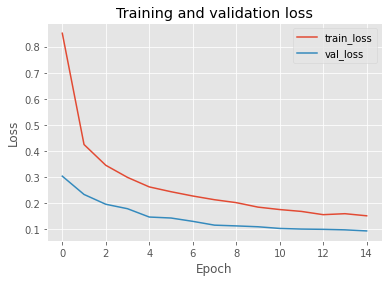

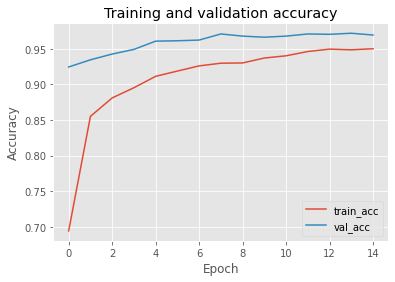

In [9]:
N = np.arange(0, 15)
plt.style.use("ggplot")

plt.figure()
plt.plot(N, hist.history["loss"], label="train_loss")
plt.plot(N, hist.history["val_loss"], label="val_loss")
plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.sep.join([config.OUTPUT_PATH, "resnet_losses.png"]))

plt.figure()
plt.plot(N, hist.history["accuracy"], label="train_acc")
plt.plot(N, hist.history["val_accuracy"], label="val_acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.sep.join([config.OUTPUT_PATH, "resnet_accuracy.png"]))

plt.show()

              precision    recall  f1-score   support

        open       0.93      0.96      0.95       388
       short       0.72      0.99      0.83       301
    mousebit       0.87      0.77      0.82       393
        spur       0.95      0.70      0.81       325
      copper       0.98      0.98      0.98       294
    pin-hole       0.96      0.98      0.97       300

    accuracy                           0.89      2001
   macro avg       0.90      0.90      0.89      2001
weighted avg       0.90      0.89      0.89      2001



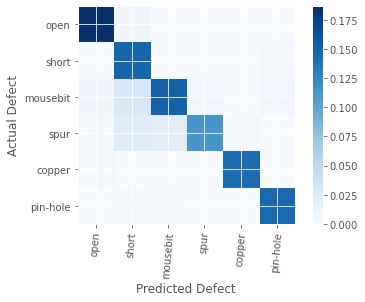

In [10]:
predictions = list()
for path in testGen.filepaths:
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    preds = model.predict(image)
    predictions.append(preds.argmax(axis=1))

#predictions = model.predict(testGen, batch_size=32)
print(classification_report(testGen.classes,
	predictions, target_names=testGen.class_indices))

cm = confusion_matrix(testGen.classes, predictions, normalize='all')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(testGen.class_indices))
plt.xticks(tick_marks, testGen.class_indices, rotation=85)
plt.yticks(tick_marks, testGen.class_indices)
plt.xlabel('Predicted Defect')
plt.ylabel('Actual Defect')
plt.savefig(os.path.sep.join([config.OUTPUT_PATH, "resnet_confusion_matrix.png"]))
plt.show()